<a href="https://colab.research.google.com/github/arvindnswamy/RemoteSensing/blob/development/MonthlyNDVI_Analysis_Hyderabad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Python example based on a GEE tutorial available at https://developers.google.com/earth-engine/classification
#This is the example that uses libsvm classifier.
#Important thing is that the image has to be a float. IT DOES NOT WORK IF THE IMAGE IS np.uint16, AS MOST LANDST
#IMAGES ARE. HENCE, I HAD TO CHANGE sat from sat = 'LANDSAT/LC08/C01/T1' to sat = 'LANDSAT/LC08/C01/T1_TOA'

import ee
from IPython.display import Image

# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=2xLp9tEQlndtLKtQzMet4zr51n2zaKxDj3TDziM9aws&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1gHsfuZ4-ogREOfV53vPP2z8KqSJOpIiVZyX7-OpTWlz_D5QFUrY7U8

Successfully saved authorization token.


In [ ]:
ee.Initialize()

def get_images(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
  image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

  images = list(map(lambda x: ee.Image(x), image_ids))

  return images

def get_image_coll(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))

  return coll

In [ ]:
p = [144]
r = [51]
sat = 'LANDSAT/LC08/C01/T1_TOA'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 15

image_list_nyc = get_images(p, r, sat, sd, ed, cc)
image_coll = get_image_coll(p, r, sat, sd, ed, cc)
#image_list_nyc

In [ ]:
'''
Functions needed to display images and features/featurecollections are given here. 
These functions are all from other sources. Mostly from google tutorials.
'''
!pip install geojson pygeoj
import geojson
import json
import pygeoj
import numpy as np


import folium


# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

  Created wheel for pygeoj: filename=PyGeoj-1.0.0-cp36-none-any.whl size=10348 sha256=e1fcf67239b2d4400c1cadca541b812a49681c04d4d1c3f1a357fb9cbf4e948e
  Stored in directory: /root/.cache/pip/wheels/7d/7c/8e/3c82fc15ee9f04d8df3e59817d2ee5499a8413341d6476c7d8
Successfully built pygeoj


In [ ]:
approxhyd = 'sample_data/' + 'AlmostCircleAroundHyderabad' +'.json'
approxBLR = 'sample_data/' + 'ApproxBengaluru' +'.json'
f = open(approxBLR)
approxGeoJSON = geojson.load(f)

approxBLREE = ee.Geometry.Polygon(np.array(approxGeoJSON['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist())

In [ ]:
def addNDWIbands(image):
  #return image.regexpRename('nd', 'ndwi');
  return image.addBands(image.normalizedDifference(['B3', 'B6']).rename('NDWI'));

def addNDVIbands(image):
  image = image.addBands(image.normalizedDifference(['B5', 'B4']).rename('NDVI'));
  return image


In [ ]:
image_coll = image_coll.map(addNDVIbands)

image_coll = image_coll.map(addNDWIbands)

In [ ]:
def addImageNDhistAnalysis(image):
  #import numpy as np
  year = ee.Date(image.get('system:time_start')).get('year')
  month = ee.Date(image.get('system:time_start')).get('month')
  day = ee.Date(image.get('system:time_start')).get('day')

  #img_data_ndwi = ee.List(image.sample(numPixels = 1000).reduceColumns(reducer=ee.Reducer.toList().repeat(1), selectors=['NDWI']).get('list'))
  #img_data_ndvi = ee.List(image.sample(numPixels = 1000).reduceColumns(reducer=ee.Reducer.toList().repeat(1), selectors=['NDVI']).get('list'))

  meanDictionary = image.select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.mean(), scale= 30, maxPixels = 1e9)
  stdevDictionary = image.select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.stdDev(), scale= 30, maxPixels = 1e9)
  #meanDictionary = image.select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.mean(), scale= 30, maxPixels = 1e9).getInfo()
  #stdevDictionary = image.select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.stdDev(), scale= 30, maxPixels = 1e9).getInfo()

  #image = image.setMulti({'year': year, 'month': month, 'day': day, 'ndwi, mean': meanDictionary['NDWI'], 'ndwi, stdev': stdevDictionary['NDWI'], 'ndvi, mean': meanDictionary['NDVI'], 'ndvi, stdev': stdevDictionary['NDVI']})
  image = image.setMulti({'year': year, 'month': month, 'day': day, 'mean': meanDictionary, 'stdev': stdevDictionary})

  return image

In [ ]:
#image_coll_test = ee.ImageCollection(image_coll.first()).map(addImageNDhistAnalysis)
image_coll_test = image_coll.map(addImageNDhistAnalysis)

#image_coll_test.first().propertyNames().getInfo()
#image_coll_test.first().get('stdev').getInfo()#

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


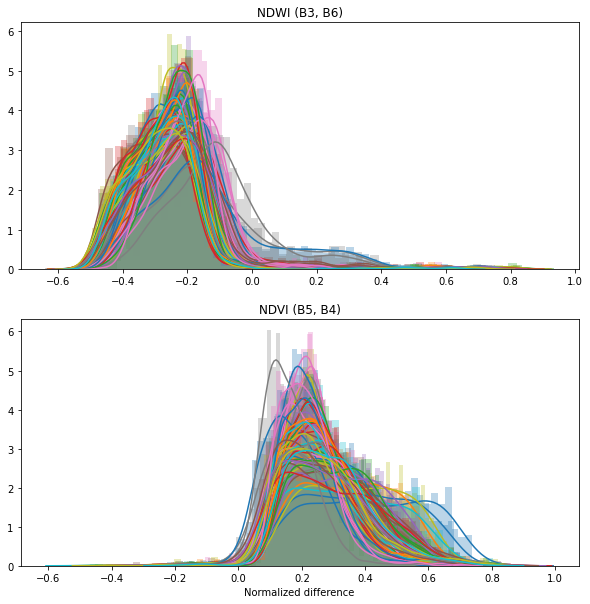

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

df = pd.DataFrame()
dfdict = {}

f, (ax1,ax2) = plt.subplots(2, figsize=(10,10))

for images in image_list_nyc[0:]:
  #images = images.clip(approxhydEE) approxBLREE
  images = images.clip(approxBLREE) 
  ndvi = images.normalizedDifference(['B5', 'B4'])
  ndwi = images.normalizedDifference(['B3', 'B6'])

  images = images.addBands(ndvi.rename('NDVI')) # band 'nd' is ndvi
  images = images.addBands(ndwi.rename('NDWI')) #band 'nd_1' is ndwi

  year = ee.Date(images.get('system:time_start')).get('year').getInfo()
  month = ee.Date(images.get('system:time_start')).get('month').getInfo()

  img_dict_ndwi = images.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['NDWI'])
  img_list_ndwi = ee.List(img_dict_ndwi.get('list'))
  img_data_ndwi = img_list_ndwi.getInfo()

  dfdict['date'] = ee.Date(images.get('system:time_start')).format().getInfo()
  dfdict['year'] = year
  dfdict['month'] = month
  dfdict['ndwi, mean'] = np.mean(img_data_ndwi)
  dfdict['ndwi, stdev'] = np.std(img_data_ndwi)

  img_data_ndvi = ee.List(images.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['NDVI']).get('list')).getInfo()

  dfdict['ndvi, mean'] = np.mean(img_data_ndvi)
  dfdict['ndvi, stdev'] = np.std(img_data_ndvi)

  df = df.append(pd.DataFrame([[ee.Date(images.get('system:time_start')).format().getInfo(), 
                                year, month, np.mean(img_data_ndwi), np.std(img_data_ndwi),
                                np.mean(img_data_ndvi), np.std(img_data_ndvi)]],
                        columns=['date', 'year', 'month', 'ndwi, mean', 'ndwi, stdev', 
                              'ndvi, mean', 'ndvi, stdev']))

  sns.distplot(img_data_ndwi, bins=50, label=str(month)+'/'+str(year), ax=ax1,
               hist_kws={'alpha':0.3})
  sns.distplot(img_data_ndvi, bins=50, label=ee.Date(images.get('system:time_start')).format().getInfo(), ax=ax2,
               hist_kws={'alpha':0.3})
#ax1.legend(loc='upper right')

ax2.set_xlabel('Normalized difference')
ax1.title.set_text('NDWI (B3, B6)')
ax2.title.set_text('NDVI (B5, B4)')

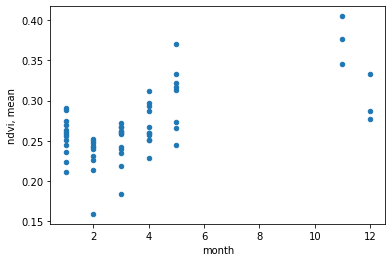

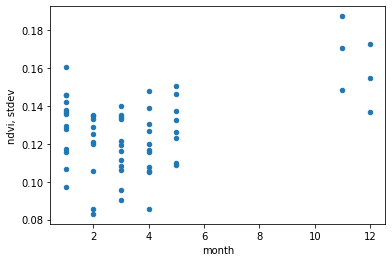

In [ ]:
df.plot.scatter(x='month', y='ndvi, mean')
df.plot.scatter(x='month', y='ndvi, stdev')

In [ ]:
ee.Date(image_coll.first().get('system:time_start')).get('day').getInfo()

7

In [ ]:
image_coll.first().get('system:band_names').getInfo()
#image_coll.first().propertyNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'BQA',
 'NDVI',
 'NDWI']

In [ ]:
image_coll.first().propertyNames().getInfo()
img_data_ndwi = ee.List(image_coll.first().sample(numPixels = 1000).reduceColumns(reducer=ee.Reducer.toList().repeat(1), selectors=['NDWI']).get('list'))
type(img_data_ndwi)

ee.ee_list.List

In [ ]:
image_coll.first().sample(numPixels = 1000)

In [ ]:
meanDictionary = image_coll.first().select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.mean(), scale= 30, maxPixels = 1e9)
stdevDictionary = image_coll.first().select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.stdDev(), scale= 30, maxPixels = 1e9)

In [ ]:
meanDictionary.getInfo()['NDVI']

0.4696940115983523

In [ ]:
image_coll_test.first().get('mean').getInfo()

{'NDVI': 0.4696940115983523, 'NDWI': -0.2572714890539351}

In [ ]:
image_coll.first().sample(numPixels = 1000).reduceColumns(reducer=ee.Reducer.toList().repeat(1), selectors=['NDWI']).get('list')

In [ ]:
image_ids = list(map(lambda x: x['id'], image_coll_test.getInfo()['features'] )) 

In [ ]:
image_coll_list = image_coll_test.toList(image_coll_test.size())

In [ ]:
[ee.Image(image_coll_list.get(n)).get('mean').getInfo() for n in range(image_coll_test.size().getInfo())]

[{'NDVI': 0.4696940115983523, 'NDWI': -0.2572714890539351},
 {'NDVI': 0.3842017925371886, 'NDWI': -0.3195683924877002},
 {'NDVI': 0.3258426404118608, 'NDWI': -0.2883485957217835},
 {'NDVI': 0.2992702647932876, 'NDWI': -0.2782305232314698},
 {'NDVI': 0.3035071906424645, 'NDWI': -0.33564243550676554},
 {'NDVI': 0.29534808982486677, 'NDWI': -0.3355029134485245},
 {'NDVI': 0.33070635763288847, 'NDWI': -0.37057193186130494},
 {'NDVI': 0.27322329030320536, 'NDWI': -0.2975190903996098},
 {'NDVI': 0.28947356965403287, 'NDWI': -0.34684356214632783},
 {'NDVI': 0.2693192349793157, 'NDWI': -0.33904591096464337},
 {'NDVI': 0.28351388538878713, 'NDWI': -0.3380577091675103},
 {'NDVI': 0.3095720520737102, 'NDWI': -0.335043344862592},
 {'NDVI': 0.30482293902167507, 'NDWI': -0.36250917619997614},
 {'NDVI': 0.2581118904284626, 'NDWI': -0.2954031620513397},
 {'NDVI': 0.2654654692593909, 'NDWI': -0.35397094649020006},
 {'NDVI': 0.2815193265967128, 'NDWI': -0.3612721217768998},
 {'NDVI': 0.27384114114740293

In [ ]:
ee.Image(image_coll_list.get(4)).get('mean').getInfo()

{'NDVI': 0.3035071906424645, 'NDWI': -0.33564243550676554}

In [ ]:
image_list_nyc[0] = image_list_nyc[0].addBands(image_list_nyc[0].normalizedDifference(['B5', 'B4']).rename('NDVI'))
image_list_nyc[0] = image_list_nyc[0].addBands(image_list_nyc[0].normalizedDifference(['B3', 'B6']).rename('NDWI'))

meanDictionary = image_list_nyc[0].select(['NDVI', 'NDWI']).reduceRegion(reducer= ee.Reducer.mean(), scale= 30, maxPixels = 1e9)

In [ ]:
meanDictionary.get('NDWI').getInfo()

-0.2572714890539351

In [ ]:
dfhyd = df

In [ ]:
dfhyd

,date,year,month,"ndwi, mean","ndwi, stdev","ndvi, mean","ndvi, stdev"
0,2013-11-07T05:11:25,2013,11,-0.243126,0.164199,0.443791,0.133249
0,2013-12-25T05:11:07,2013,12,-0.305075,0.176421,0.350228,0.125104
0,2014-01-10T05:10:56,2014,1,-0.280000,0.174799,0.300250,0.109276
0,2014-01-26T05:10:47,2014,1,-0.277428,0.181287,0.281139,0.097204
0,2014-02-11T05:10:34,2014,2,-0.313871,0.165293,0.278501,0.103714
...,...,...,...,...,...,...,...
0,2020-01-27T05:09:47,2020,1,-0.314552,0.155014,0.301750,0.108712
0,2020-02-28T05:09:38,2020,2,-0.319143,0.130930,0.277461,0.110830
0,2020-03-15T05:09:32,2020,3,-0.356571,0.112736,0.301562,0.126797
0,2020-03-31T05:09:22,2020,3,-0.332440,0.111479,0.280717,0.104335


In [ ]:
df

,date,year,month,"ndwi, mean","ndwi, stdev","ndvi, mean","ndvi, stdev"
0,2013-11-07T05:12:37,2013,11,-0.260495,0.147776,0.404639,0.187480
0,2014-01-10T05:12:07,2014,1,-0.244060,0.151257,0.269880,0.127939
0,2014-01-26T05:11:59,2014,1,-0.271787,0.160609,0.258947,0.136727
0,2014-02-11T05:11:45,2014,2,-0.255310,0.136348,0.226423,0.105818
0,2014-02-27T05:11:33,2014,2,-0.273901,0.145290,0.242825,0.121114
0,2014-03-15T05:11:22,2014,3,-0.297693,0.129202,0.258938,0.132893
0,2014-03-31T05:11:05,2014,3,-0.270389,0.131777,0.234707,0.095748
0,2014-04-16T05:10:48,2014,4,-0.275321,0.134268,0.250458,0.105875
0,2014-05-02T05:10:35,2014,5,-0.274102,0.130147,0.244233,0.108694
0,2014-05-18T05:10:23,2014,5,-0.246062,0.104318,0.265611,0.109891


In [ ]:
df

NameError: ignored